# Kaggle Setup

In [ ]:
# !kaggle datasets download -d iabhishekofficial/mobile-price-classification

Import the zipped file in the path from Kaggle API.

Extract the `.csv` files.

In [ ]:
import zipfile
import os

zip_file_path = "mobile-price-classification.zip"

# Define the directory where you want to extract the contents
extract_dir = "."

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extract_dir)

# Optionally, you can remove the zip file after extraction
os.remove(zip_file_path)

FileNotFoundError: [Errno 2] No such file or directory: 'mobile-price-classification.zip'

***

Dataset Link: https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification.

useful link:
https://goldinlocks.github.io/Bayesian-logistic-regression-with-pymc3/

# **0 - Imports and dataset description**

In [2]:
import os
from google.colab import drive
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/Bayesian Analysis")

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly

import sklearn
import imblearn
import xgboost as xgb

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)

In [4]:
import pymc as pm
import arviz as az

Columns description

1. **blue**: Has bluetooth or not
2. **clock_speed**: Speed at which microprocessor executes instructions
3. **dual_sim**: Has dual sim support or not
4. **fc**: Front Camera mega pixels
5. **four_g**: Has 4G or not
6. **int_memory**: Internal Memory in Gigabytes
7. **m_dep**: Mobile Depth in cm
8. **mobile_wt**: Weight of mobile phone
9. **n_cores**: Number of cores of processor
10. **pc**: Primary Camera mega pixels
11. **px_height**: Pixel Resolution Height
12. **px_width**: Pixel Resolution Width
13. **ram**: Random Access Memory in Megabytes
14. **sc_h**: Screen Height of mobile in cm
15. **sc_w**: Screen Width of mobile in cm
16. **talk_time**: Longest time that a single battery charge will last when you are
17. **three_g**: Has 3G or not
18. **touch_screen**: Has touch screen or not
19. **wifi**: Has wifi or not
20. **id**: ID
21. **battery_power**: Total energy a battery can store in one time measured in mAh

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
train.shape, test.shape

((2000, 21), (1000, 21))

In my opinion the test set is too big with respect to the training set...

Map the label `price_range` to binary.

In [7]:
mapping = {0:0,
           1:0,
           2:1,
           3:1}

train['price_range'] = train['price_range'].map(mapping)

In [8]:
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,0
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,1
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,1
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,1
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,0


# **1 - Data Pre-Processing**

Inspect the columns data types.

In [ ]:
train.dtypes

battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object

Check for null values.

In [ ]:
train.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

Check for duplicate values.

In [ ]:
train.duplicated().sum()

0

***

In [ ]:
for col in train.columns:
    print(f"Column: {col}", train[col].value_counts(normalize=True),
          "\n--------------------------------------------------")

Column: battery_power 1872    0.0030
618     0.0030
1589    0.0030
1715    0.0025
1807    0.0025
         ...  
660     0.0005
1452    0.0005
1005    0.0005
1372    0.0005
858     0.0005
Name: battery_power, Length: 1094, dtype: float64 
--------------------------------------------------
Column: blue 0    0.505
1    0.495
Name: blue, dtype: float64 
--------------------------------------------------
Column: clock_speed 0.5    0.2065
2.8    0.0425
2.3    0.0390
2.1    0.0380
1.6    0.0380
2.5    0.0370
0.6    0.0370
1.4    0.0350
1.3    0.0340
1.5    0.0335
2.0    0.0335
1.9    0.0325
0.7    0.0320
2.9    0.0310
1.8    0.0310
1.0    0.0305
1.7    0.0300
2.2    0.0295
0.9    0.0290
2.4    0.0290
0.8    0.0290
1.2    0.0280
2.6    0.0275
2.7    0.0275
1.1    0.0255
3.0    0.0140
Name: clock_speed, dtype: float64 
--------------------------------------------------
Column: dual_sim 1    0.5095
0    0.4905
Name: dual_sim, dtype: float64 
--------------------------------------------------
Col

# **2 - Exploratory Data Analysis**

### 2.1 - Variables Distributions

In [ ]:
binary_columns = []
nonbinary_columns = []

for col in train.columns:
    if train[col].nunique() == 2:
        binary_columns.append(col)
    else:
        nonbinary_columns.append(col)

len(binary_columns) + len(nonbinary_columns)

21

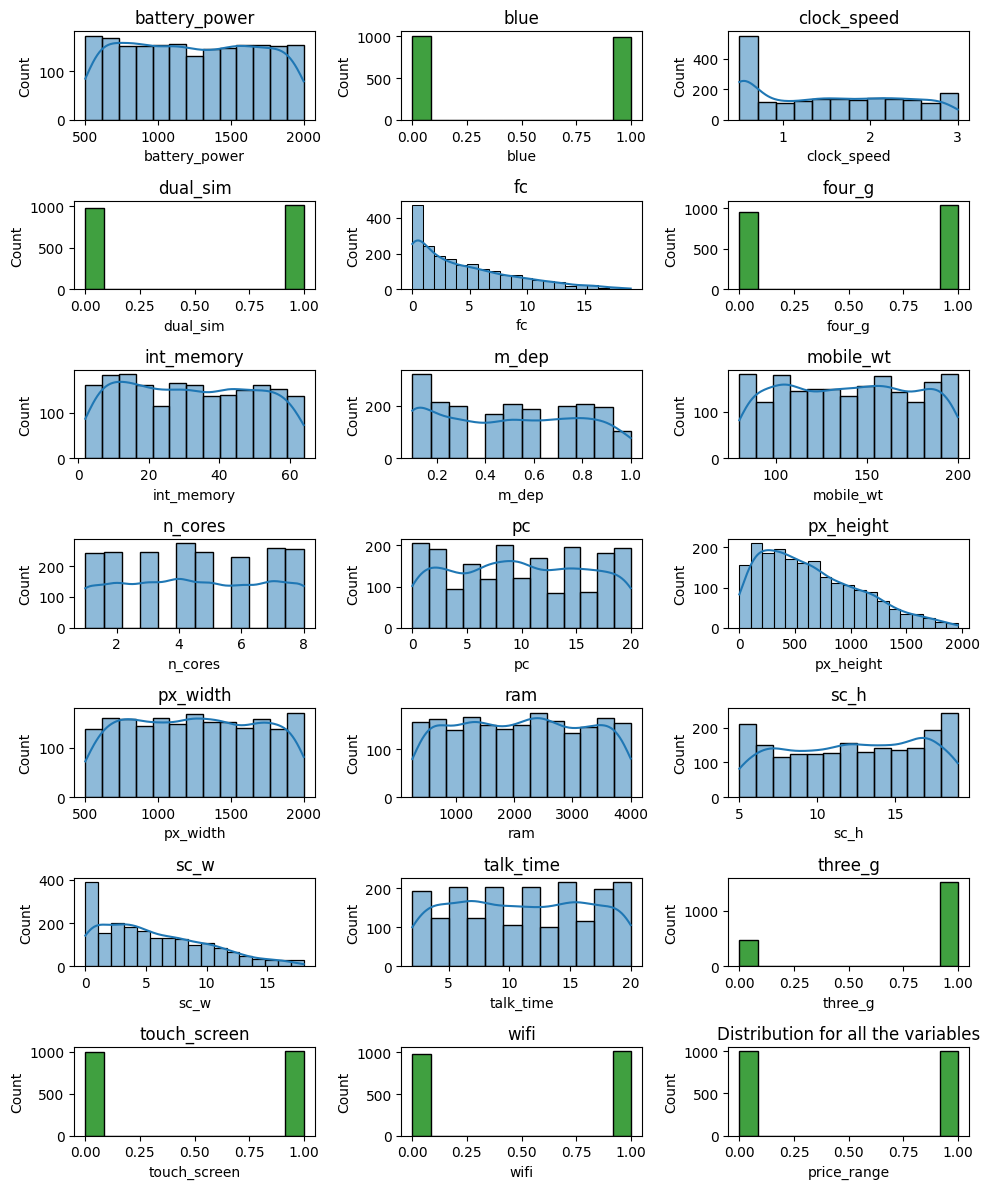

In [ ]:
fig, axes = plt.subplots(7, 3, figsize=(10,12), tight_layout=True)
axes = axes.flatten()

for i, col in enumerate(train.columns):
    if col in binary_columns or col == 'price_range':
        sns.histplot(train[col], ax=axes[i],color='green')
    else:
        sns.histplot(train[col], ax=axes[i], kde=True)
    axes[i].set_title(col)
plt.title('Distribution for all the variables')
plt.show()

In [ ]:
np.corrcoef(train['three_g'], train['four_g'])

array([[1.        , 0.58424556],
       [0.58424556, 1.        ]])

In [ ]:
train['four_g'].loc[train['three_g'] == 1].value_counts(normalize=True)

1    0.684833
0    0.315167
Name: four_g, dtype: float64

***

### 2.2 - Correlation Matrix

In [ ]:
correlation_matrix = train.corr()

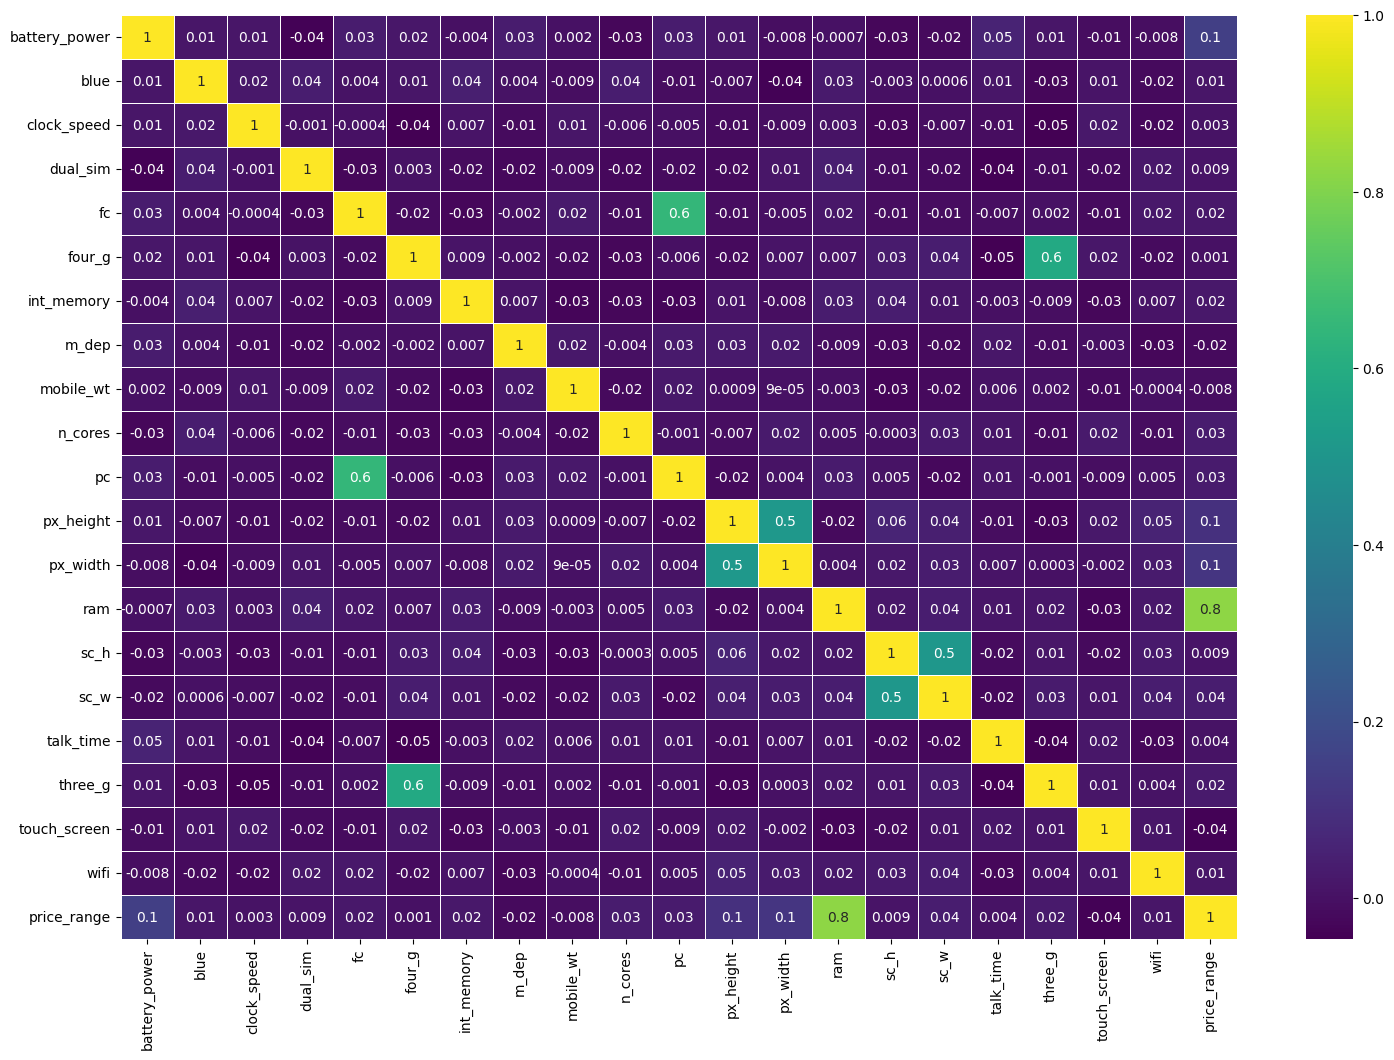

In [ ]:
plt.figure(figsize=(18,12))
sns.heatmap(correlation_matrix, annot=True, linewidths=0.5, fmt=".0g", cmap='viridis')
plt.show()

### 2.3 - Box Plots

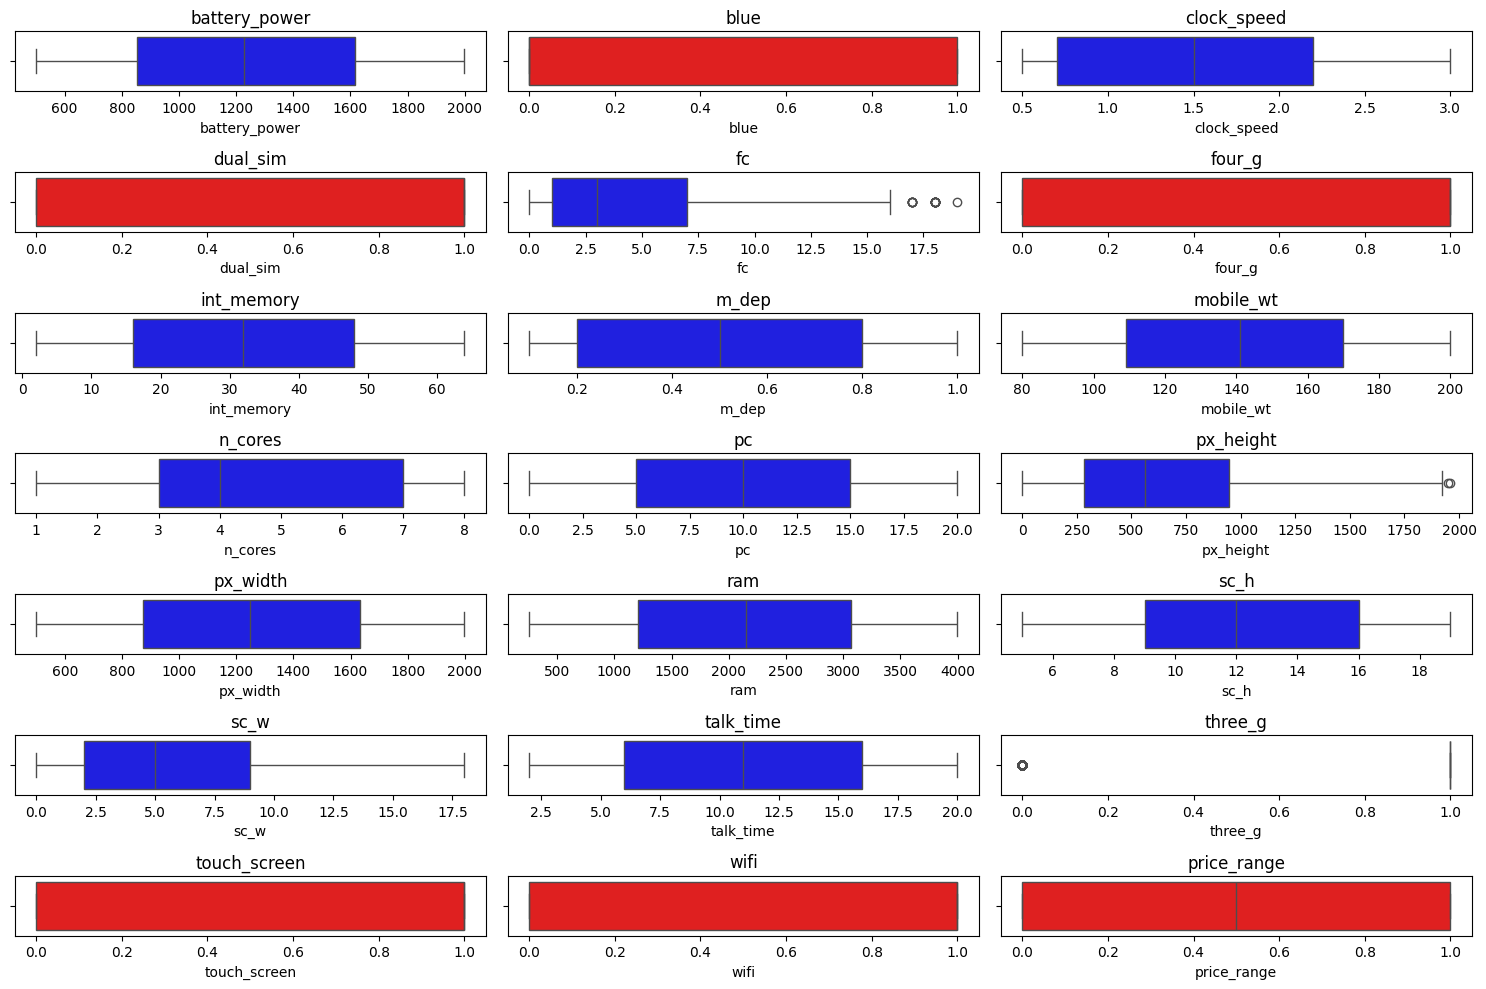

In [ ]:
# Filter numerical and binary columns
numerical_columns = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
binary_columns = [col for col in train.columns if train[col].nunique() == 2]

# Define subplot layout for numerical features
num_numerical_columns = len(numerical_columns)
num_rows_numerical = (num_numerical_columns // 3) + (num_numerical_columns % 3 > 0)  # Adjust for odd number of numerical columns

# Create subplots for numerical features
fig, axes = plt.subplots(num_rows_numerical, 3, figsize=(15, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot box plots for numerical features
for i, column in enumerate(numerical_columns):
    color = 'blue'  # Default color for numerical features
    if column in binary_columns:
        color = 'red'  # Change color for binary features
    sns.boxplot(x=train[column], ax=axes[i], color=color)
    axes[i].set_title(column)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

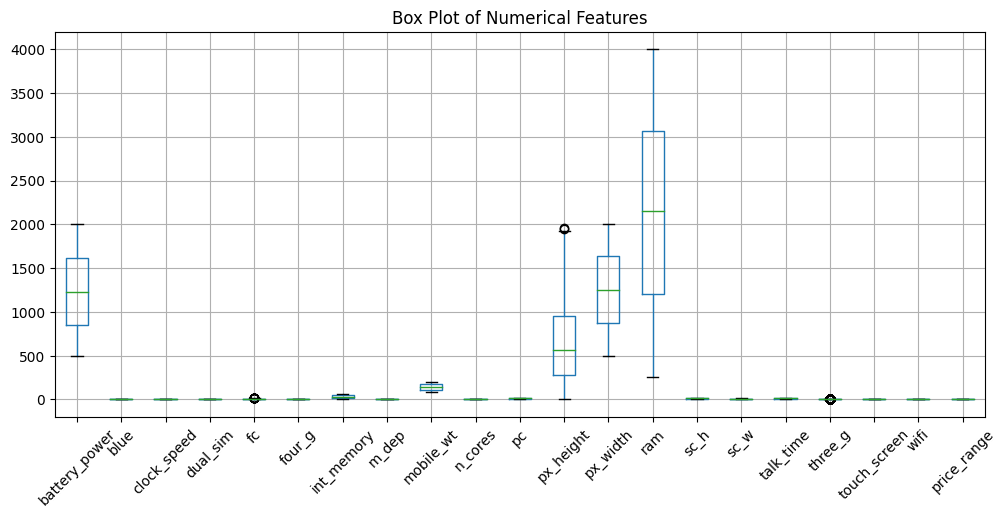

In [35]:
# Plot box plots for numerical features
plt.figure(figsize=(12, 5))
train.boxplot()
plt.title('Box Plot of Numerical Features')
plt.xticks(rotation=45)
plt.show()

### 2.4 - Histograms according to `price_range`

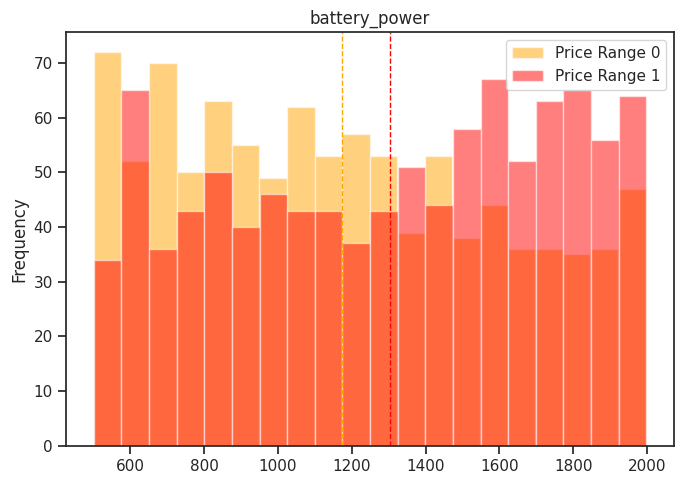

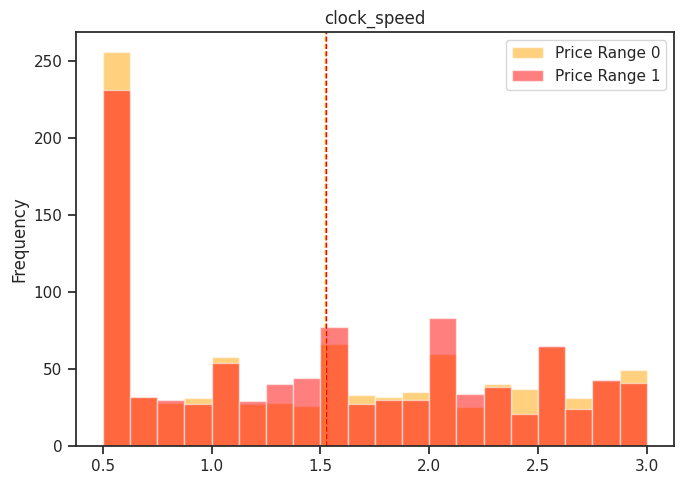

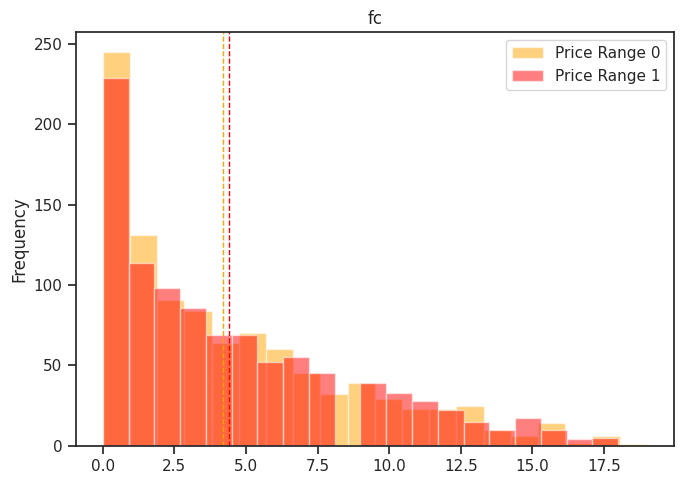

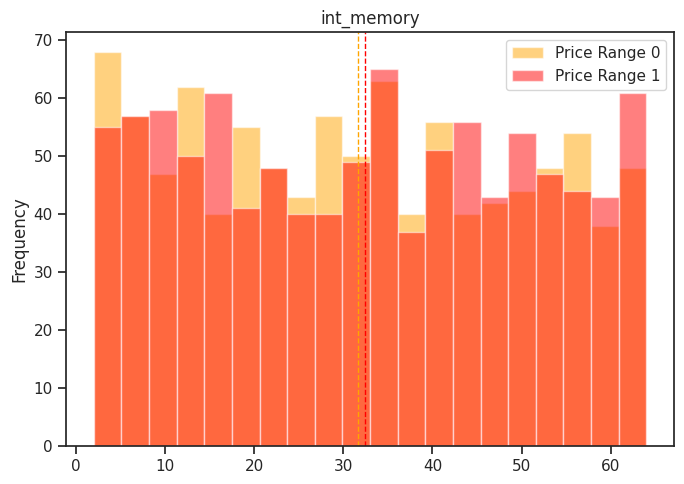

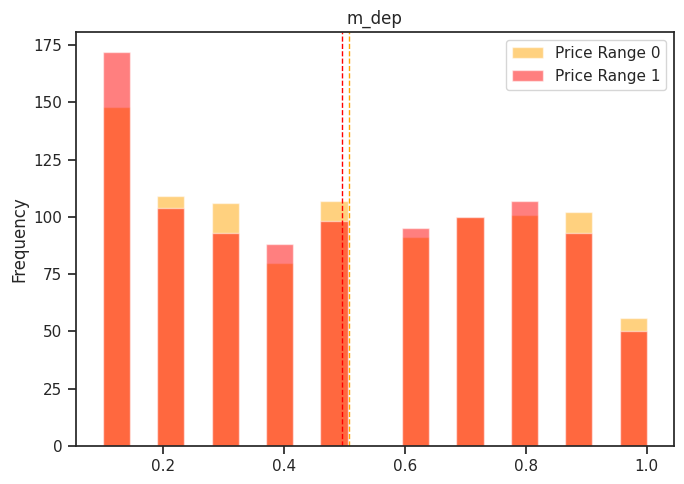

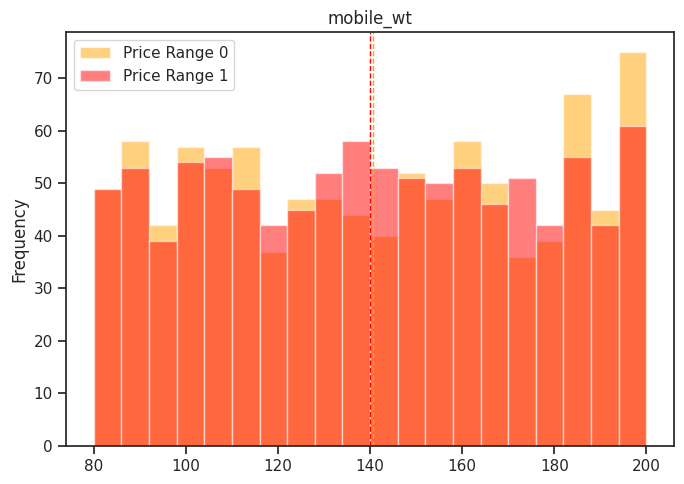

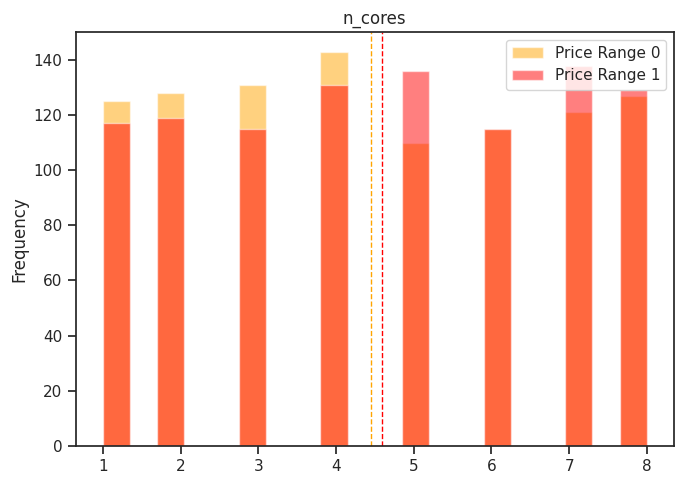

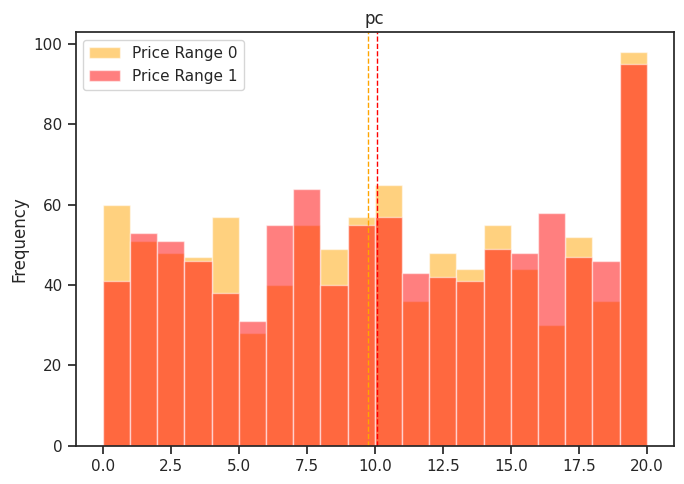

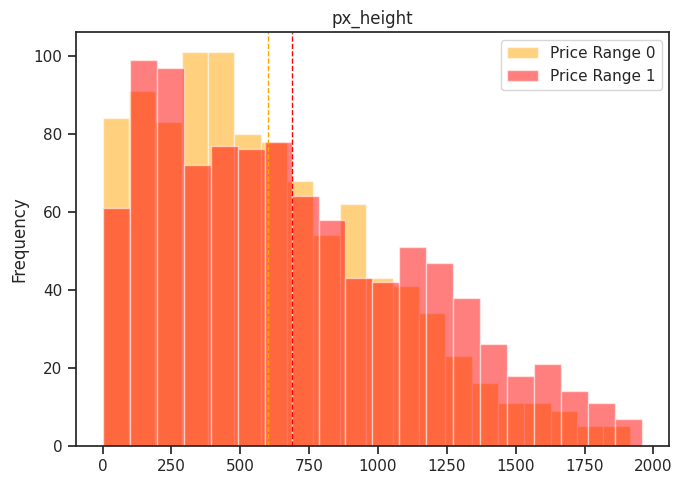

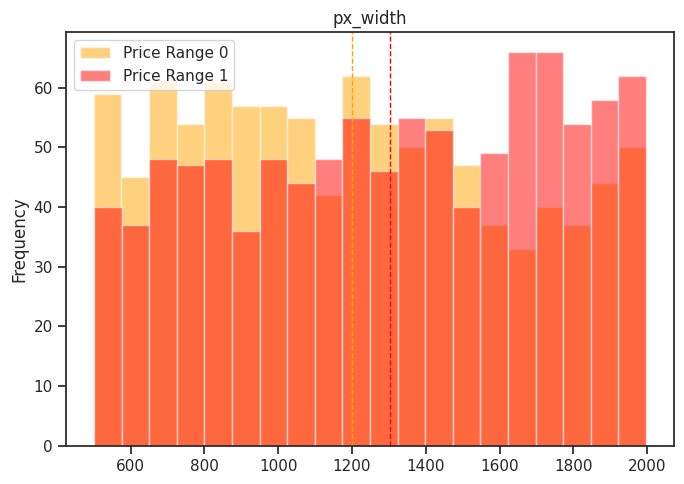

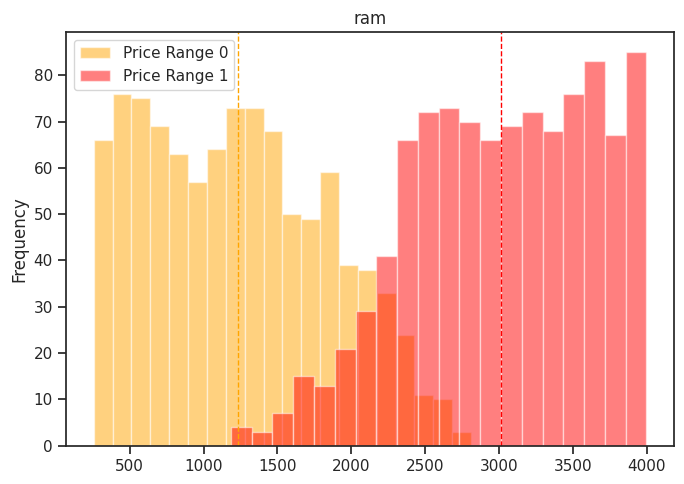

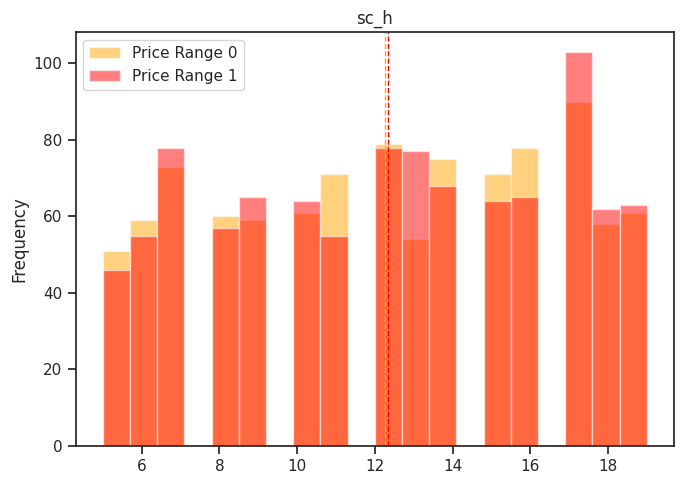

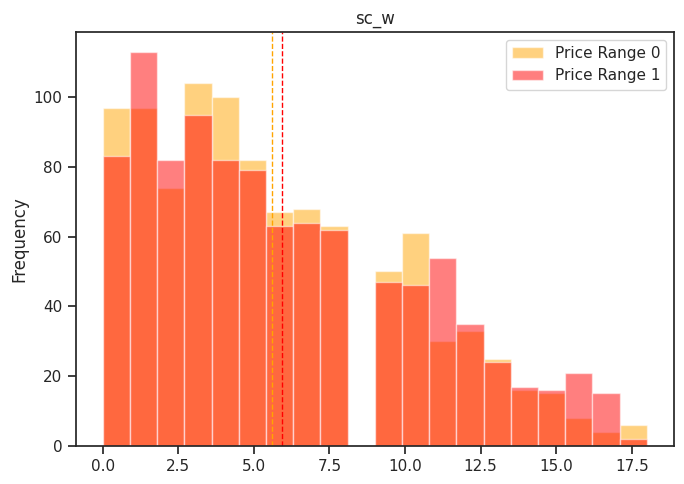

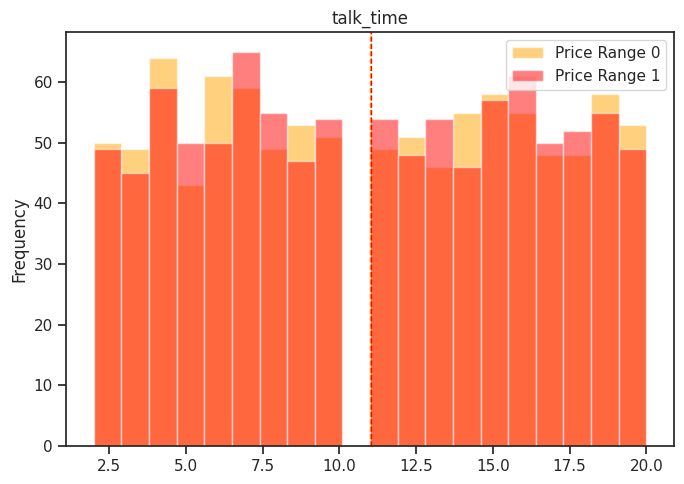

In [ ]:
sns.set_theme(style="ticks")

# Filter binary and numerical columns
binary_columns = [col for col in train.columns if train[col].nunique() == 2]
numerical_columns = [col for col in train.columns if train[col].dtype in ['int64', 'float64'] and col not in binary_columns]

# Define custom colors for price ranges
price_range_colors = {0: 'orange', 1: 'red'}

# Plot histograms for numerical features
for column in numerical_columns:
    plt.figure(figsize=(7, 5))

    # Plot histograms with different colors for each price range
    for price_range, color in price_range_colors.items():
        subset_data = train[train['price_range'] == price_range]
        plt.hist(subset_data[column], bins=20, color=color, alpha=0.5, label=f'Price Range {price_range}')

        # Plot mean line for each price range
        mean_value = subset_data[column].mean()
        plt.axvline(mean_value, color=color, linestyle='--', linewidth=1)

    plt.title(column)
    plt.xlabel('')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

# **3 - Scaling the data**

In [9]:
# Exclude the target variable from scaling
features = train.drop(columns=['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi', 'price_range'])

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the features and transform them
scaled_features = scaler.fit_transform(features)

# Convert the scaled features back to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

# Add the unscaled target variable back to the DataFrame
scaled_df['blue'] = train['blue']
scaled_df['dual_sim'] = train['dual_sim']
scaled_df['four_g'] = train['four_g']
scaled_df['three_g'] = train['three_g']
scaled_df['touch_screen'] = train['touch_screen']
scaled_df['wifi'] = train['wifi']
scaled_df['price_range'] = train['price_range']

# Check the shape of the scaled DataFrame
print("Shape of scaled DataFrame:", scaled_df.shape)

Shape of scaled DataFrame: (2000, 21)


### 3.1 - Inspect box plots after the Standard Scaling

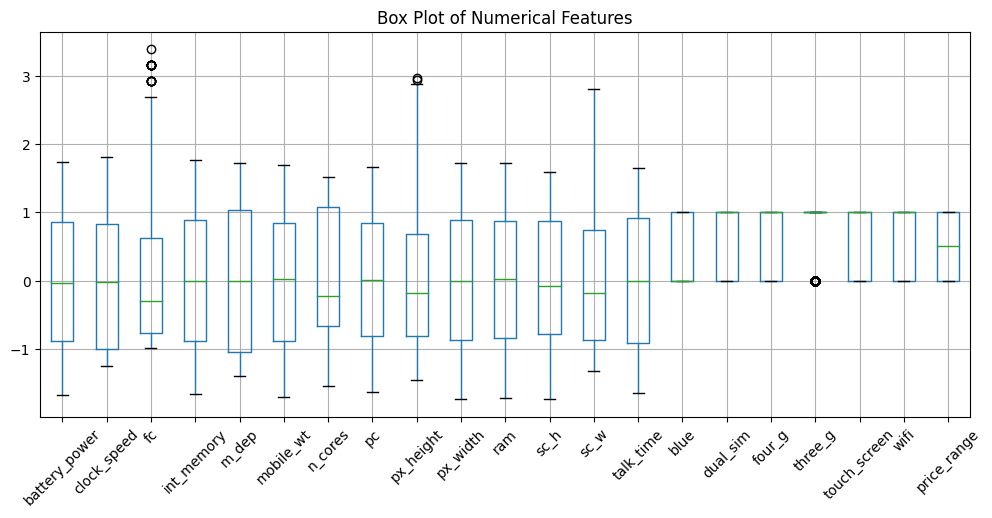

In [37]:
plt.figure(figsize=(12,5))
scaled_df.boxplot()
plt.title('Box Plot of Numerical Features')
plt.xticks(rotation=45)
plt.show()

# **4 - Bayesian Logistic Regression using PyMC**

### 4.1 - Perform train-val split.

In [10]:
X = scaled_df.loc[:, scaled_df.columns != 'price_range']
y = scaled_df['price_range']

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

### 4.2 - Create the Bayesian Logistic Model

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'epsilon'}>,
        <Axes: title={'center': 'epsilon'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

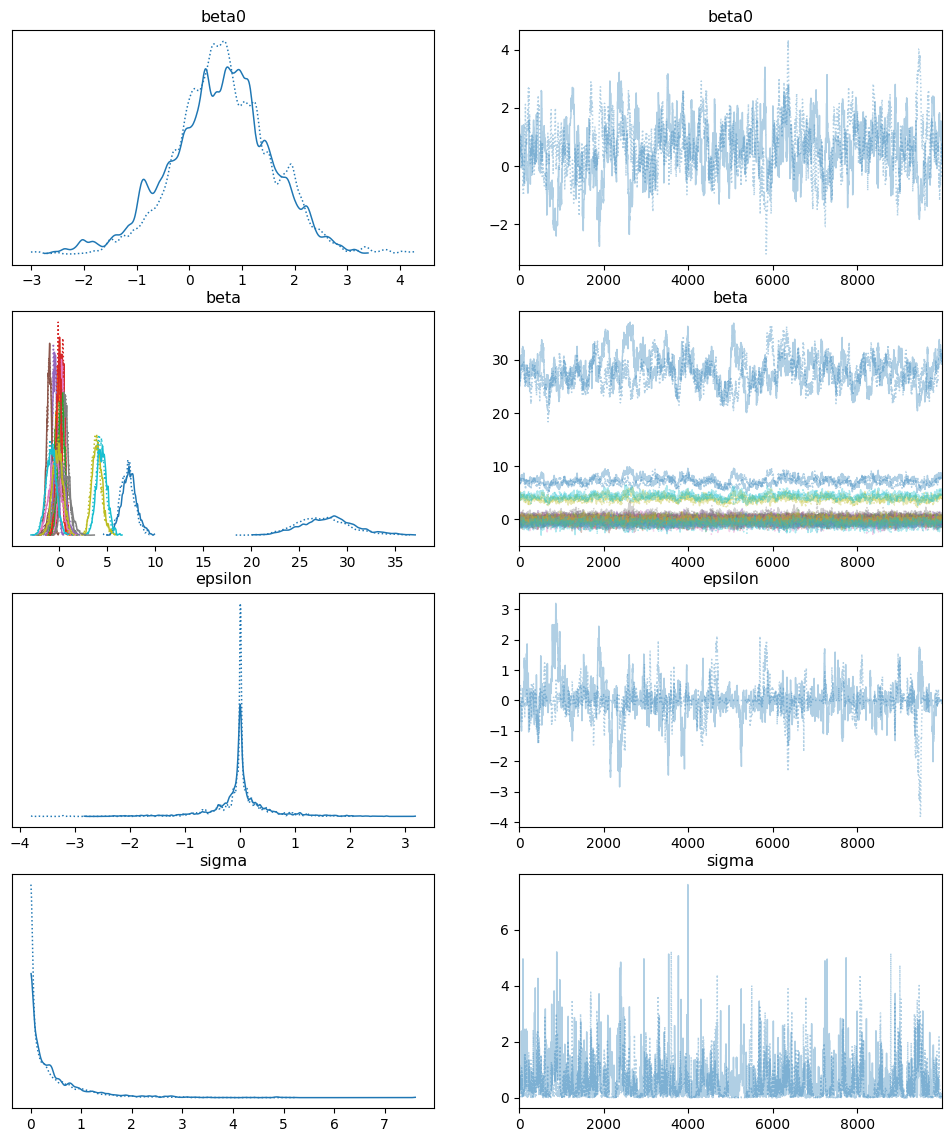

In [18]:
with pm.Model() as logistic_model:

    # Priors for the coefficients
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=5, shape=X_train.shape[1])

    sigma = pm.Gamma('sigma', alpha=0.6, beta=1)
    epsilon = pm.Normal('epsilon', mu=0, sigma=sigma)

    # Linear combination of features
    linear_combination = linear_combination =  beta0 + \
                          beta[0] * X_train["battery_power"] + \
                          beta[1] * X_train["clock_speed"] + \
                          beta[2] * X_train["fc"] + \
                          beta[3] * X_train["int_memory"] + \
                          beta[4] * X_train["m_dep"] + \
                          beta[5] * X_train["mobile_wt"] + \
                          beta[6] * X_train["n_cores"] + \
                          beta[7] * X_train["pc"] + \
                          beta[8] * X_train["px_height"] + \
                          beta[9] * X_train["px_width"] + \
                          beta[10] * X_train["ram"] + \
                          beta[11] * X_train["sc_h"] + \
                          beta[12] * X_train["sc_w"] + \
                          beta[13] * X_train["talk_time"] + \
                          beta[14] * X_train["blue"] + \
                          beta[15] * X_train["dual_sim"] + \
                          beta[16] * X_train["four_g"] + \
                          beta[17] * X_train["three_g"] + \
                          beta[18] * X_train["touch_screen"] + \
                          beta[19] * X_train["wifi"]

    p = pm.math.invlogit(linear_combination + epsilon)

    # Likelihood function
    likelihood = pm.Bernoulli('likelihood', p=p, observed=y_train)

    # Use Metropolis-Hastings algorithm for sampling
    trace = pm.sample(draws=10000, tune=5000, step=pm.Metropolis(proposal_sd=1.0), random_seed=5)

# Plot the posterior distribution of the coefficients
pm.plot_trace(trace, figsize=(12,14))

In [324]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [230]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.624,0.932,-1.166,2.310,0.072,0.051,171.0,256.0,1.01
beta[0],7.196,0.753,5.743,8.587,0.071,0.051,120.0,227.0,1.03
beta[1],-0.089,0.282,-0.621,0.429,0.006,0.004,2201.0,3009.0,1.00
beta[2],-0.145,0.336,-0.804,0.474,0.009,0.006,1375.0,2403.0,1.00
beta[3],0.329,0.270,-0.137,0.881,0.005,0.004,2527.0,3526.0,1.00
beta[4],-0.498,0.265,-0.980,0.016,0.006,0.004,1892.0,3159.0,1.00
beta[5],-1.052,0.282,-1.565,-0.492,0.012,0.009,571.0,1163.0,1.01
beta[6],0.219,0.272,-0.298,0.718,0.006,0.004,2204.0,2903.0,1.00
beta[7],0.575,0.364,-0.069,1.310,0.010,0.007,1311.0,2356.0,1.00
beta[8],3.883,0.519,2.939,4.870,0.041,0.030,173.0,308.0,1.02


It is helpful to convert the xArray - generated in the `pm.Model()` - into a usual Pandas DataFrame. But it is in *wide* format, thus a deeper indexing will be needed.

In [231]:
trace_df = az.InferenceData.to_dataframe(trace)
trace_df

,chain,draw,"(posterior, beta0)","(posterior, beta[0], 0)","(posterior, beta[10], 10)","(posterior, beta[11], 11)","(posterior, beta[12], 12)","(posterior, beta[13], 13)","(posterior, beta[14], 14)","(posterior, beta[15], 15)","(posterior, beta[16], 16)","(posterior, beta[17], 17)","(posterior, beta[18], 18)","(posterior, beta[19], 19)","(posterior, beta[1], 1)","(posterior, beta[2], 2)","(posterior, beta[3], 3)","(posterior, beta[4], 4)","(posterior, beta[5], 5)","(posterior, beta[6], 6)","(posterior, beta[7], 7)","(posterior, beta[8], 8)","(posterior, beta[9], 9)","(posterior, epsilon)","(posterior, sigma)","(sample_stats, accepted[0], 0)","(sample_stats, accepted[1], 1)","(sample_stats, accepted[2], 2)","(sample_stats, accepted[3], 3)","(sample_stats, scaling[0], 0)","(sample_stats, scaling[1], 1)","(sample_stats, scaling[2], 2)","(sample_stats, scaling[3], 3)","(sample_stats, accept[0], 0)","(sample_stats, accept[1], 1)","(sample_stats, accept[2], 2)","(sample_stats, accept[3], 3)"
0,0,0,1.637104,6.827368,26.843706,0.256214,-0.197005,-0.012476,-0.575493,-0.282854,-0.393540,0.507166,-1.051423,-1.114237,0.051904,-0.212329,0.170675,-0.470526,-0.962095,0.256107,0.776603,3.777046,4.002224,0.008307,1.667702,0.0,0.20,0.0,1.0,1.0,0.976025,2.371842,0.409412,2.628969e-06,0.297817,4.785935e-06,5.069297e-01
1,0,1,1.637104,6.827368,26.843706,0.256214,-0.197005,-0.012476,-0.575493,-0.172245,-0.393540,0.507166,-1.090176,-1.287058,0.051904,-0.212329,0.170675,-0.470526,-0.962095,0.256107,0.776603,3.777046,4.466374,-0.048982,1.667702,0.0,0.20,0.0,1.0,1.0,0.976025,2.371842,0.409412,9.620962e-08,0.331529,1.363064e-10,1.315395e+00
2,0,2,1.637104,6.827368,26.478713,0.256214,-0.197005,-0.012476,-1.248878,0.001294,-0.301177,0.507166,-1.090176,-1.287058,0.051904,-0.212329,0.170675,-0.470526,-0.962095,0.256107,0.776603,3.777046,4.449607,-0.413250,0.946860,0.0,0.25,1.0,1.0,1.0,0.976025,2.371842,0.409412,2.125240e-17,0.284283,2.576303e+00,7.391776e-01
3,0,3,1.637104,6.827368,26.478713,0.256214,-0.197005,0.387089,-1.248878,0.001294,-0.951547,0.715276,-1.090176,-1.271496,0.051904,-0.212329,0.170675,-0.724606,-0.962095,0.256107,0.776603,3.956254,4.101885,-0.413250,0.366244,0.0,0.35,1.0,0.0,1.0,0.976025,2.371842,0.409412,2.550128e-03,0.371838,1.520766e+00,7.160450e-02
4,0,4,1.637104,6.827368,26.052254,-0.129955,0.308223,0.387089,-1.248878,0.814025,-0.130995,0.652494,-1.090176,-1.271496,-0.041070,-0.051442,0.170675,-0.724606,-0.962095,-0.309608,0.776603,4.048354,3.409519,-0.637379,0.366244,0.0,0.55,0.0,1.0,1.0,0.976025,2.371842,0.409412,7.788401e-03,0.629531,2.231294e-112,1.062694e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1,9995,0.428021,8.072615,30.451718,0.446710,-0.038753,-0.153081,-0.499530,0.096574,-0.345923,0.659365,0.444956,-0.066768,0.495158,0.236170,0.688489,-0.052393,-0.826659,-0.065040,-0.288014,3.980679,4.527283,-0.101504,0.061791,1.0,0.20,1.0,1.0,1.0,1.000000,1.000000,1.000000,3.722435e-01,0.259478,1.020574e+00,6.680278e-01
19996,1,9996,0.428021,8.195109,30.399077,-0.061489,-0.038753,-0.153081,0.021934,0.096574,-0.345923,0.609490,0.444956,-0.066768,0.495158,0.236170,0.688489,-0.052393,-0.826659,0.163231,-0.288014,3.980679,4.527283,-0.101504,0.061791,0.0,0.30,0.0,0.0,1.0,1.000000,1.000000,1.000000,3.343261e-05,0.323270,1.860819e-02,5.153107e-12
19997,1,9997,0.428021,8.195109,30.182445,-0.061489,-0.038753,-0.153081,-0.750955,0.096574,-0.345923,-0.499443,0.444956,-0.504695,0.495158,0.236170,0.830045,-0.413531,-1.415742,0.163231,0.613534,3.980679,4.527283,-0.101504,0.061791,0.0,0.40,0.0,0.0,1.0,1.000000,1.000000,1.000000,1.976848e-02,1.607750,2.183585e-01,1.527772e-05
19998,1,9998,0.798098,8.195109,29.720148,-0.061489,-0.038753,-0.153081,-0.636936,0.096574,-0.345923,-0.587971,0.444956,-0.504695,-0.252161,0.236170,0.830045,-0.538353,-1.415742,0.163231,0.613534,3.980679,4.521183,0.052720,0.055868,1.0,0.30,1.0,1.0,1.0,1.000000,1.00

Define a function that plots the histogram of the posterior distribution for all the coefficients, along with its kernel density line:

In [232]:
def plot_posterior(trace, num_var):

  from matplotlib.ticker import FormatStrFormatter

  """
  This function creates the histogram plot for each of the posterior
  distributions computed when creating the model.

  Args:
    trace: dataframe of the trace.
    num_var: number of variables included in the model (intercept excluded).
  """

  for i in range(num_var):
    plt.figure(figsize=(4,4))
    plt.hist(trace_df[('posterior',f'beta[{i}]', i)],
             bins=30,
             density=True,
             color='skyblue',
             edgecolor='black', lw=0.15)
    sns.kdeplot(trace_df[('posterior',f'beta[{i}]', i)],
                color='red',
                linestyle='--')
    plt.yticks([])
    plt.ylabel(' ')
    plt.xlabel(' ')
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.title(f'Posterior distribution for column: "{train.columns[i]}"')
    plt.show()

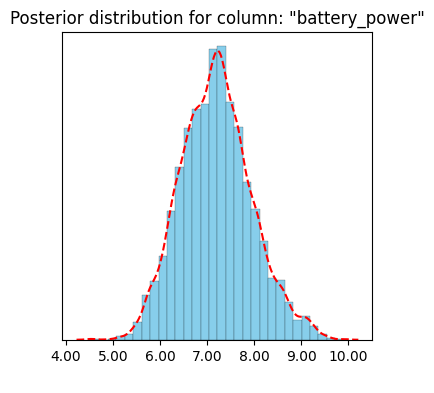

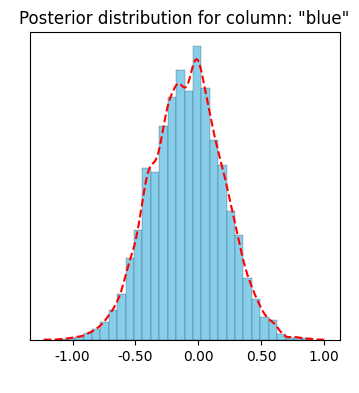

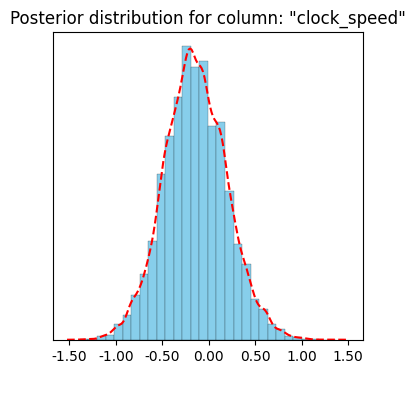

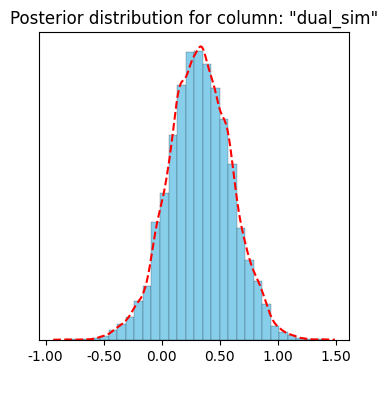

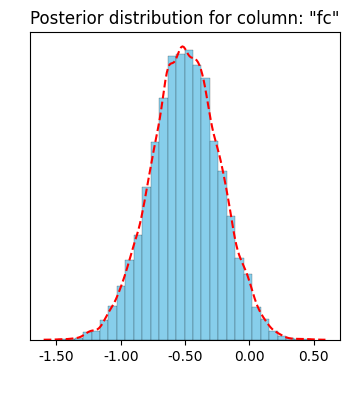

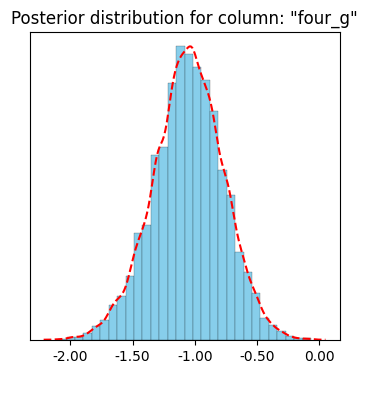

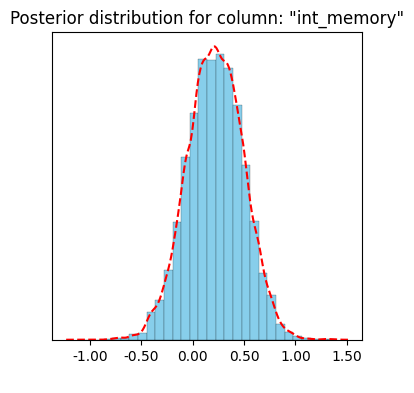

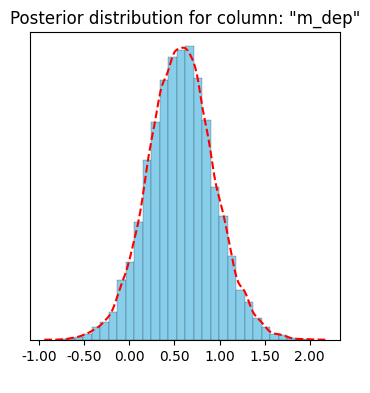

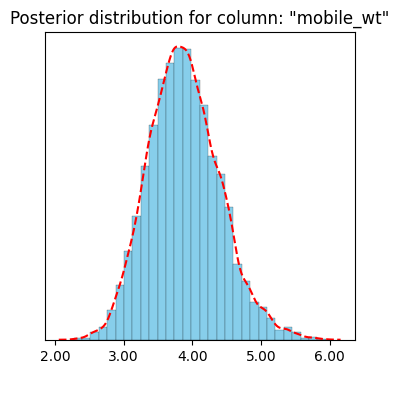

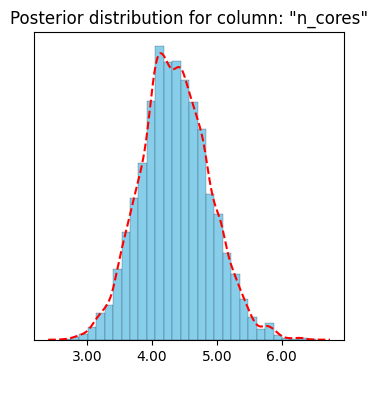

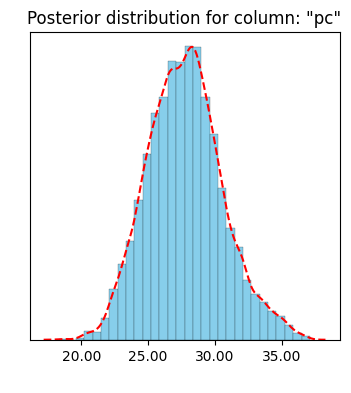

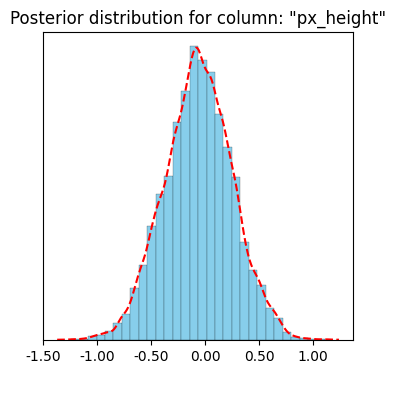

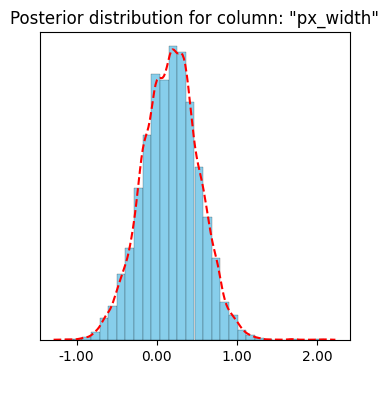

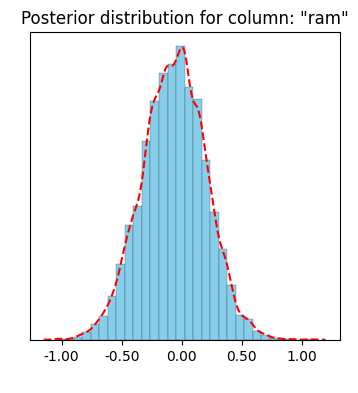

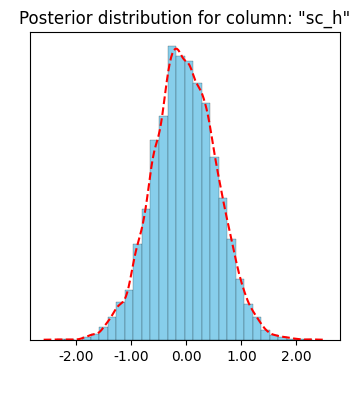

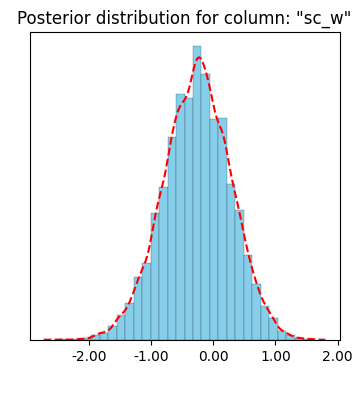

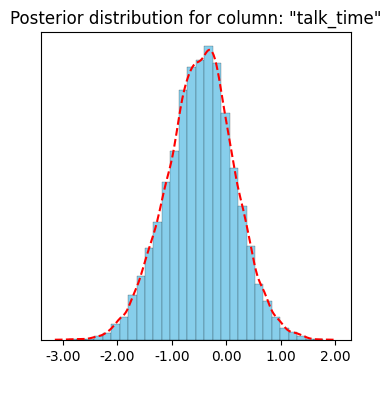

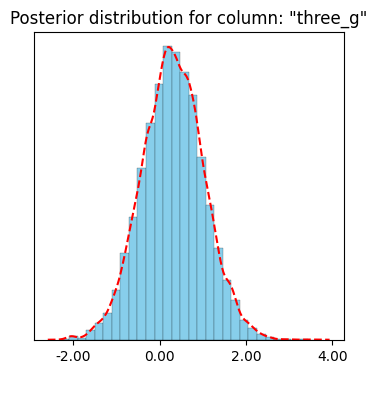

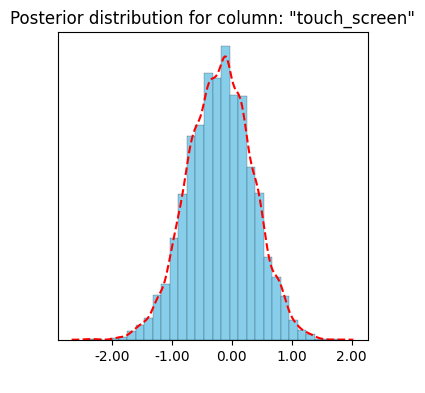

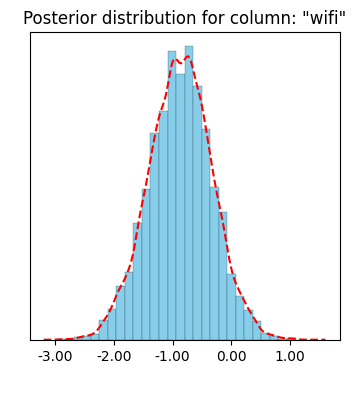

In [326]:
plot_posterior(trace=trace_df, num_var=X_train.shape[1])

Access the column having the mean of the estimated posterior distributions.

In [237]:
coefficients_dict = dict(zip(pm.summary(trace)['mean'][:21].index,
                        pm.summary(trace)['mean'][:21].values))
coefficients_dict

{'beta0': 0.624,
 'beta[0]': 7.196,
 'beta[1]': -0.089,
 'beta[2]': -0.145,
 'beta[3]': 0.329,
 'beta[4]': -0.498,
 'beta[5]': -1.052,
 'beta[6]': 0.219,
 'beta[7]': 0.575,
 'beta[8]': 3.883,
 'beta[9]': 4.358,
 'beta[10]': 27.781,
 'beta[11]': -0.062,
 'beta[12]': 0.173,
 'beta[13]': -0.065,
 'beta[14]': -0.03,
 'beta[15]': -0.264,
 'beta[16]': -0.471,
 'beta[17]': 0.31,
 'beta[18]': -0.194,
 'beta[19]': -0.866}

In [240]:
logistic_model = LogisticRegression()
logistic_model.classes_ = np.unique(y_train)

# Set Coefficients
# Extract coefficients from the dictionary
intercept = np.array(coefficients_dict['beta0'])
coefficients = np.array(list(coefficients_dict.values())[1:])

# Set coefficients in the logistic regression model
logistic_model.intercept_ = np.array([intercept])
logistic_model.coef_ = np.array([coefficients])

# Fit the Model
y_val_predictions = logistic_model.predict(X_val)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [246]:
y_val_predictions[:6]

array([0, 1, 0, 1, 0, 0])

Evaluate the model using the Accuracy Score

In [245]:
accuracy_score(y_val, y_val_predictions)

0.99

In [247]:
f1_score(y_val, y_val_predictions)

0.98989898989899

### 4.3 - Bayesian approach using the median

Compute the median for the distribution of the intercept.

In [274]:
median_intercept = np.median(trace_df['posterior', 'beta0'])
median_intercept

0.6297469189466259

Compute the median for each variable distribution: `vars_median`.

In [295]:
vars_median = []

for i in range(0,20):
  median_value = np.median(trace_df[('posterior', f'beta[{i}]', i)])
  vars_median.append(median_value)

In [296]:
len(vars_median)

20

Create a dictionary that has the coefficients.

In [297]:
vars_median.insert(0, median_intercept)
median_coefficients_values = vars_median
median_coefficients_values

[0.6297469189466259,
 7.178938152532674,
 -0.0810097821620004,
 -0.15404655426238445,
 0.32833976333121884,
 -0.49939759953830193,
 -1.0468391335599458,
 0.22007034949700624,
 0.5738675111544914,
 3.859607155980483,
 4.338846437366295,
 27.72124982899084,
 -0.06139509252101644,
 0.181920950374925,
 -0.05855721697296659,
 -0.038589756055112265,
 -0.25236658104991944,
 -0.452987480237916,
 0.3093327532292517,
 -0.1848387907598485,
 -0.8577551501661856]

In [298]:
median_coefficients_dict = dict(zip(pm.summary(trace)['mean'][:21].index,
                                    median_coefficients_values))
median_coefficients_dict

{'beta0': 0.6297469189466259,
 'beta[0]': 7.178938152532674,
 'beta[1]': -0.0810097821620004,
 'beta[2]': -0.15404655426238445,
 'beta[3]': 0.32833976333121884,
 'beta[4]': -0.49939759953830193,
 'beta[5]': -1.0468391335599458,
 'beta[6]': 0.22007034949700624,
 'beta[7]': 0.5738675111544914,
 'beta[8]': 3.859607155980483,
 'beta[9]': 4.338846437366295,
 'beta[10]': 27.72124982899084,
 'beta[11]': -0.06139509252101644,
 'beta[12]': 0.181920950374925,
 'beta[13]': -0.05855721697296659,
 'beta[14]': -0.038589756055112265,
 'beta[15]': -0.25236658104991944,
 'beta[16]': -0.452987480237916,
 'beta[17]': 0.3093327532292517,
 'beta[18]': -0.1848387907598485,
 'beta[19]': -0.8577551501661856}

In [299]:
logistic_model_median = LogisticRegression()
logistic_model_median.classes_ = np.unique(y_train)

# Set Coefficients
# Extract coefficients from the dictionary
median_intercept = np.array(median_intercept)
median_coefficients = np.array(list(median_coefficients_dict.values())[1:])

# Set coefficients in the logistic regression model
logistic_model_median.intercept_ = np.array([median_intercept])
logistic_model_median.coef_ = np.array([median_coefficients])

# Fit the Model
y_val_predictions_median = logistic_model_median.predict(X_val)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [300]:
accuracy_score(y_val, y_val_predictions_median)

0.99

### 4.4 - Frequentist Logistic Regression

In [314]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [315]:
accuracy = logistic_model.score(X_val, y_val)
print("Accuracy:", accuracy)

Accuracy: 0.99


# **5 - Bayesian Decision Trees**

Potential source: https://github.com/UBS-IB/bayesian_tree.

In [28]:
# Define Bayesian decision tree model
with pm.Model() as bayesian_tree_model:
    # Priors for decision tree hyperparameters
    max_depth = pm.DiscreteUniform('max_depth', lower=1, upper=10)
    min_samples_split = pm.DiscreteUniform('min_samples_split', lower=2, upper=20)

    # Define likelihood function (Bernoulli likelihood for binary classification)
    y_prob = pm.Bernoulli('y_prob', p=0.5, shape=len(X_train))

    # Decision tree classifier
    tree = pm.Deterministic('tree', np.argmax(y_prob))

    # Likelihood of data
    tree_likelihood = pm.Bernoulli('tree likelihood', p=y_prob, observed=y_train)

    # Sample from the posterior distribution
    tree_trace = pm.sample(1000, tune=500, random_seed=42)

# Make predictions on test set
with bayesian_tree_model:
    ppc = pm.sample_posterior_predictive(tree_trace, samples=500)

y_pred_bayesian_tree = np.mean(ppc['tree'], axis=0) > 0.5
accuracy_score(y_val, y_pred_bayesian_tree)

ValueError: order must be one of 'C', 'F', 'A', or 'K' (got 'tree')

#################################################################################

### **hide**

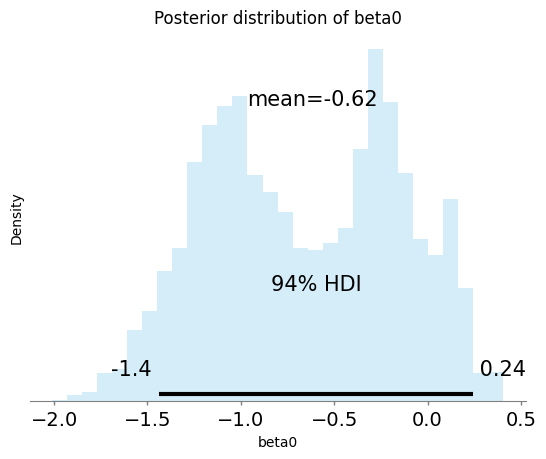

This works


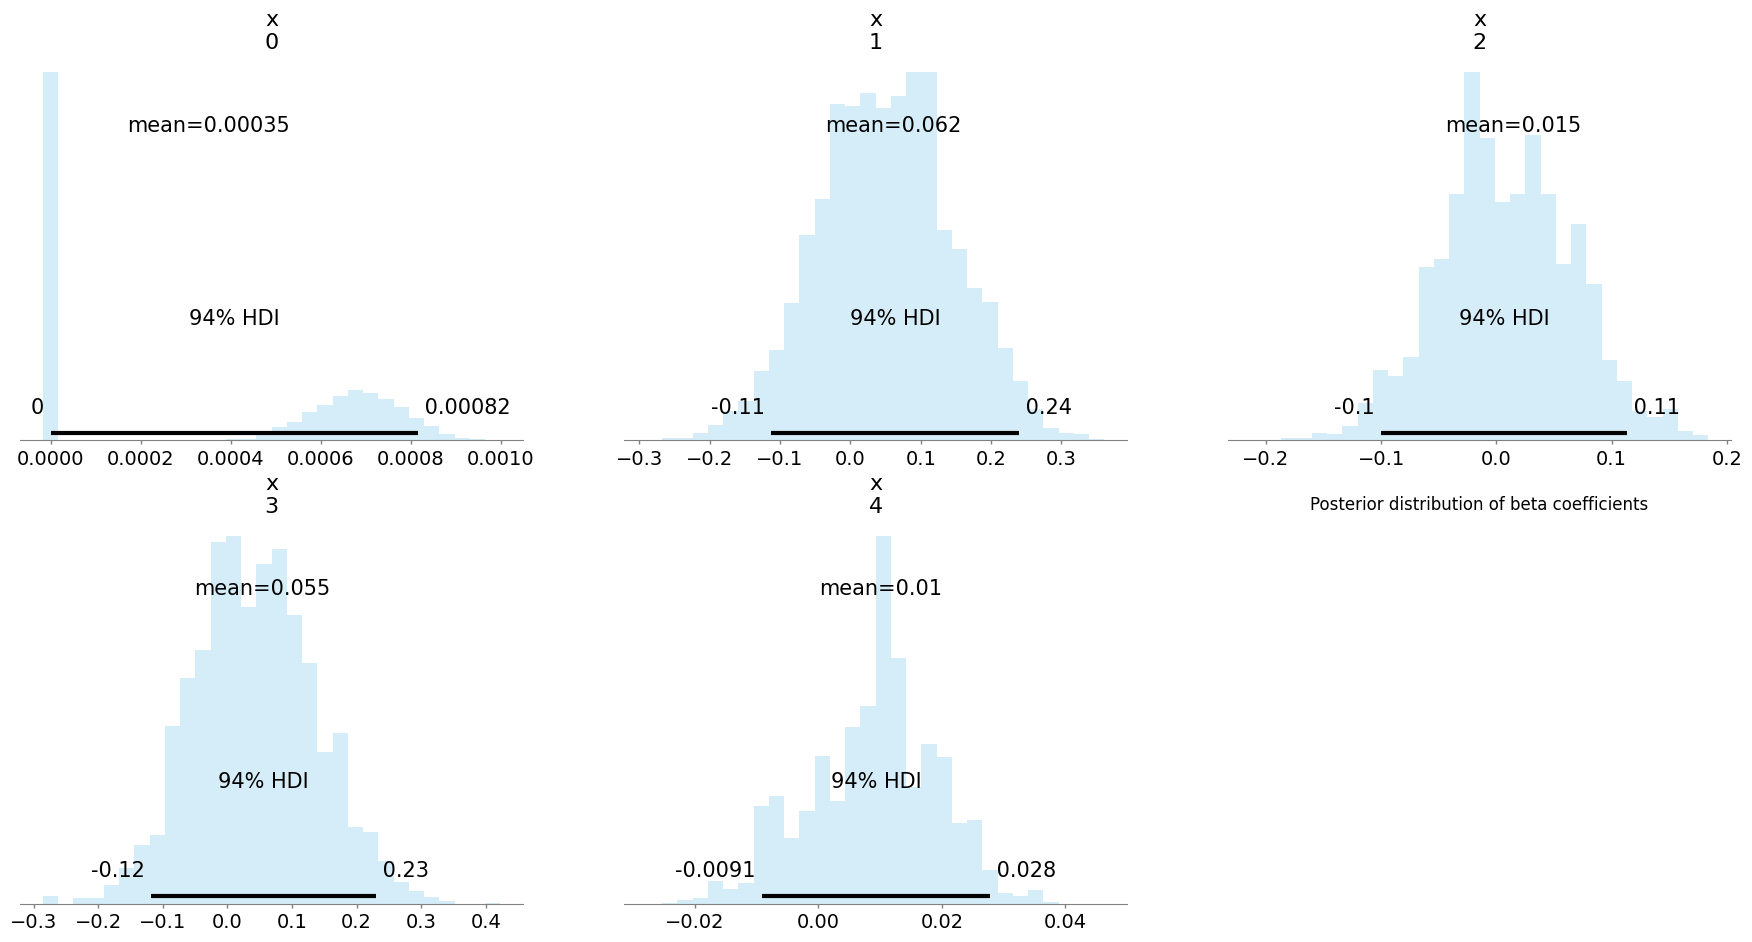

In [ ]:
# Accessing the posterior distribution of the coefficients
posterior_beta0 = trace.posterior['beta0'].values
posterior_beta = trace.posterior['beta'].values

# Plotting the posterior distribution of beta0
az.plot_posterior(posterior_beta0, kind='hist', bins=30, color='skyblue', point_estimate='mean')
plt.title('Posterior distribution of beta0')
plt.xlabel('beta0')
plt.ylabel('Density')
plt.show()

***

### post hide

What the two panels should represent, but fail in doing it:

Output: The function generates a grid of trace plots, where each plot corresponds to a parameter in the model. Each trace plot typically consists of two panels:
- Left Panel: This panel shows the trace of the parameter over the iterations of the MCMC algorithm. It provides information about the convergence behavior of the MCMC chain. Ideally, you want to see a well-mixed chain with no obvious trends or patterns, indicating convergence to the target distribution.
- Right Panel: This panel shows the histogram of the parameter values sampled during the MCMC process. It represents the posterior distribution of the parameter. You can use it to examine the shape of the distribution and estimate the uncertainty in the parameter estimates.

Quoting ChatGPT:
- The number of observations (rows) corresponds to the number of data points or samples you have in your dataset.
- The number of posterior predictive samples (columns) corresponds to the number of samples drawn from the posterior predictive distribution during the sampling process.

This is not the case though

---

### Simple model manually specified (attempt)

Try a logistic regression model using only 3 variables, such as:
- RAM
- Battery Power
- Pixel Height

$$
y = β_{0} + β_{1} × RAM + β_{2} × {batterypower}
$$

In [ ]:
with pm.Model() as manual_logistic_model:

  intercept = pm.Normal('intercept', mu=0, sigma=100)
  beta_1 = pm.Normal('beta_1', mu=0, sigma=100)
  beta_2 = pm.Normal('beta_2', mu=0, sigma=100)

  likelihood = pm.invlogit(
      intercept + beta_1 * train.ram + beta_2 * train.battery_power
  )

  pm.Bernoulli(name='Logit', p=likelihood, observed=train.price_range)

Formal definition of the model:

\begin{array}{rcl}
            \text{intercept} &\sim & \operatorname{Normal}(0,~100)\\\text{beta_1} &\sim & \operatorname{Normal}(0,~100)\\\text{beta_2} &\sim & \operatorname{Normal}(0,~100)\\\text{Logit} &\sim & \operatorname{Bernoulli}(f(\text{beta_2},~\text{intercept},~\text{beta_1}))
            \end{array}

Graphical visualization of the model

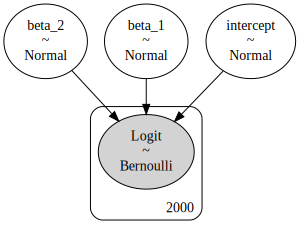

In [ ]:
pm.model_to_graphviz(manual_logistic_model)

Compute MAP: Maximum A-posteriori Probability

In [ ]:
with manual_logistic_model:
  manual_map_estimate = pm.find_MAP()

In [ ]:
def print_map(result):
  return pd.Series(
      {k: np.ndarray.item(v) for k,v in result.items()}
  )

In [ ]:
print_map(manual_map_estimate)

NameError: name 'print_map' is not defined

Great Regression: everything 0...